# Project:
# Web Scraping Job Postings and Predicting Salary and Job Categories



In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
#from HTMLParser import HTMLParser
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer
#from nltk.corpus import stopwords
#from nltk.tag import pos_tag
#from nltk.tokenize import WordPunctTokenizer
from textblob import TextBlob
from textacy.preprocess import preprocess_text
from sklearn.feature_extraction.text import TfidfVectorizer

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import patsy
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
import os
from gensim import corpora, models, matutils
from collections import defaultdict

In [2]:
df = pd.read_csv('./formatted_job_listings.csv', sep=',', encoding='utf-8', index_col=None)

df.shape

(1960, 39)

In [3]:
df.head()

,city,company,jobkey,jobtitle,snippet,url,search_term,company_abbrev,jobtitle_length,snippet_clean,jobtitle_clean,jobtitle_noun_phrases,snippet_noun_phrases,jobtitle_words,snippet_words,jobtitle_stem,snippet_stem,snippet_stem_string,jobtitle_stem_string,data,advanc,experienc,role,team,look,princip,level,play,scienc,lead,statist,scientist,maintain,develop,JT_princip,JT_scientist,JT_data,salary_estimate,salary_categories
0,Redmond,Microsoft,8f2960110f91289e,Principal Data Scientist,We are looking for an experienced principal le...,http://www.indeed.com/viewjob?jk=8f2960110f912...,data science,Microsoft,3,we are looking for an experienced principal le...,principal data scientist,[data scientist],"[principal level data scientist, lead role, da...","[principal, data, scientist]","[we, are, looking, for, an, experienced, princ...","[princip, data, scientist]","[we, are, look, for, an, experienc, princip, l...",we are look for an experienc princip level dat...,princip data scientist,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,132071,2
1,Seattle,Facebook,c822b64a1008e72a,"Data Scientist, Analytics",The <b>Data</b> <b>Scientist</b> Analytics rol...,http://www.indeed.com/viewjob?jk=c822b64a1008e...,data science,Facebook,3,the data scientist analytics role has work acr...,data scientist analytics,"[data scientist, analytics]","[data scientist analytics role, areas building...","[data, scientist, analytics]","[the, data, scientist, analytics, role, has, w...","[data, scientist, analyt]","[the, data, scientist, analyt, role, has, work...",the data scientist analyt role has work across...,data scientist analyt,2,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,132071,2
2,Seattle,Amazon Corporate LLC,088d06342a3c0613,Data Scientist,Amazon is seeking a <b>Data</b> <b>Scientist</...,http://www.indeed.com/viewjob?jk=088d06342a3c0...,data science,Amazon,2,amazon is seeking a data scientist to join the...,data scientist,[data scientist],"[data scientist, previous experience, data sci...","[data, scientist]","[amazon, is, seeking, a, data, scientist, to, ...","[data, scientist]","[amazon, is, seek, a, data, scientist, to, joi...",amazon is seek a data scientist to join the co...,data scientist,2,0,0,1,1,0,0,0,0,0,0,0,2,0,0,0,1,1,132071,2
3,Seattle,Amazon Corporate LLC,219629e50af0388b,Data Engineer,3+ years in relevant experience as <b>data</b>...,http://www.indeed.com/viewjob?jk=219629e50af03...,data science,Amazon,2,3 years in relevant experience as data enginee...,data engineer,[data engineer],"[relevant experience, data engineer data scien...","[data, engineer]","[3, years, in, relevant, experience, as, data,...","[data, engin]","[3, year, in, relev, experi, as, data, engin, ...",3 year in relev experi as data engin data scie...,data engin,2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,132071,2
4,Renton,XDuce,020aaa78301c721d,Associate Technical Architect,Senior programmer or <b>Data</b> <b>scientist<...,http://www.indeed.com/viewjob?jk=020aaa78301c7...,data science,XDuce,3,senior programmer or data scientist experience...,associate technical architect,[associate technical architect],"[senior programmer, data scientist experience,...","[associate, technical, architect]","[senior, programmer, or, data, scientist, expe...","[associ, technic, architect]","[senior, programm, or, data, scientist, experi...",senior programm or data scientist experi with ...,associ technic architect,3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,132071,2


# Modeling

## Category Prediction: Which terms predict category of job?

#### Again, let's try a DecisionTreeClassifier first. Let's see if the CountVectorizer matrix from the job description title or snippet can predict the job category as approximated by the search terms used on indeed.com.

In [25]:
# The job titles themselves are not cleanly segmented into groups but do contain key terms, so the vector counts
# could make useful predictors. I'll use the search terms a my job category target column.

df['jobtitle_stem_string'].value_counts()

data scientist                                                                     26
data analyst                                                                       18
data engin                                                                         14
senior softwar engin                                                               14
softwar engin                                                                      13
busi intellig engin                                                                13
senior data scientist                                                              13
softwar develop engin                                                              11
product manag                                                                       9
busi intellig analyst                                                               8
sr data scientist                                                                   6
busi analyst                                          

In [26]:
# reading in the vector count matrices for the jobtitles and the snippets
cvec_jt_df = pd.read_csv('cvec_jt.csv', sep=',', encoding='utf-8', index_col=None)
cvec_sn_df = pd.read_csv('cvec_sn.csv', sep=',', encoding='utf-8', index_col=None)

In [27]:
# The vector counts on job titles:
cvec_jt_top500 = cvec_jt_df.transpose().sort_values(0, ascending=False).head(500).transpose()

cvec_jt_top500.head(10)

,princip,scientist,data,sas,sap,sam,scala,salesforcecom,salesforc,scale,sale,s3,rule,rsde,rout,role,robot,riskfraud,risk,account,richardson,reward,replenish,report,repres,represent,req,requir,research,resourc,respons,restaur,retail,retriev,revenu,review,revolution,scalabl,sce,scc,reliabl,scrum,sde,sdet,sdm,sdr,search,seattl,seattlebas,seattlebay,secur,select,self,selfservic,sell,seller,scope,scientistus,scientisttechn,scientistarch,scharp,scienc,scienceanalyt,scienti,scientistai,scientistambi,scientistb,scientistquest,scientistbi,scientistbusi,scientistdialogu,scientistlargescal,scientistnatur,scientistposition5,remot,relev,seo,programmersenior,principl,print,prioriti,privaci,privat,process,procur,product,productdata,productprogram,prof,profession,professor,program,programm,principalsenior,prime,price,pr,portugues,posit,postdoc,postdoctor,potenti,power,practic,prevent,preconstruct,predict,prep,prepar,presal,presid,programmat,project,relationship,promis,realiti,realtim,receiv,receptionist,recognit,recommend,recruit,recruitertal,redmond,redshift,region,registrar10,registri,rekognit,relat,real,rank,railroad,push,promot,protect,prototyp,provid,public,publish,python,r0004240,qa,qae,qlikview,qualiti,queri,quicksight,senior,server,pool,trauma,trms,tsp,tsql,ture,turk,tv,tx,ui,undergradu,understand,understandin,uniform,univers,urgent,urolog,trigger,transport,servic,transit,teradata,term,territori,test,text,ticket,time,tool,toplog,tpm,track,traffic,train,transact,transform,usabl,usc,usca,user,w2,wa,warehous,warranti,washington,web,woot,work,workplac,workspac,writer,writerposit,ww,xbox,yard,vrar,vp,voic,verif,ux,uxui,v1,valu,vauto,vendor,vertic,visual,vice,video,virtual,visa,vision,visionml,temporari,technologist,technolog,ss1072,solut,sourc,sourcer,spanish,speak,special,specialist,speech,splunk,sql,sqldatabas,sqltsqlw2,sr,srprincip,ss1007,softwar,softlin,social,signal,sharepoint,shift,ship,shop,shopper,si,simpl,snr,simul,site,skill,skyrocket,smart,snow,ss1040,ssas,technician,ssis,supervisor,suppli,support,survey,sustain,sw,sync,systemsbellevu,ta0r046,tableau,talent,tax,team,tech,technic,suit,success,subscript,statistician,stack,staf,staff,staffvirtu,starbuck,statist,statisticiandata,studio,storag,store,strateg,strategi,strategist,student,portfolio,pnwseattl,ace,crs,csm,currenc,custom,cyber,d2cs,dac,danger,dashboard,databas,decis,deep,deliveri,demand,design,desk,cs,crm,fast,credit,consultantbusi,consum,content,continu,contract,control,convert,coopinternship,coordin,core,corpor,cortana,cosmos,cost,counsel,desktop,dev,develop,devic,engin,engineeranalyst,engineerdata,engineertech,enterpris,estat,etl,evangelist,event,execut,expans,experi,expert,export,fall,engag,end,enabl,dynam,devop,digit,direct,director,discoveri,distribut,ec2,emerg,ecommerc,econom,economist,ecosystem,elast,email,consult,construct,consid,beauti,analyt,android,appli,applic,architect,architectur,area,artifici,assist,associ,assur,autom,aw,azur,b2b,analystseattl,analyst,analysi,advisori,acquisit,ad,administr,advanc,advertis,advisor,ai,america,air,alexa,algo,algorithm,amazon,amazonfresh,backend,behavior,connect,bi,chain,classif,client,clinic,cloud,coach,commerc,commerci,communiti,compens,complianc,compon,comput,concept,confidenti,certif,central,center,build,bie,big,bing,biolog,block,brand,busi,ce,buyer,calibr,campaign,capac,card,care,fashion,fatal,pnt,microsoft,mobil,model,monet,monitor,ms,mts1,multipl,music,na,nacf,nation,nativ,natur,net,network,ml,mgr,fba,mgmt,lend,level,licens,lifelong,local,locat,logist,loyalti,machin,manag,manageramazon,market,master,mechan,media,new,nlp,northwest,offic,peopletech,percept,perform,person,pharmaci,phd,php,pipelin,plan,plant,platform,play
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [28]:
cvec_jt_top500.head()

,princip,scientist,data,sas,sap,sam,scala,salesforcecom,salesforc,scale,sale,s3,rule,rsde,rout,role,robot,riskfraud,risk,account,richardson,reward,replenish,report,repres,represent,req,requir,research,resourc,respons,restaur,retail,retriev,revenu,review,revolution,scalabl,sce,scc,reliabl,scrum,sde,sdet,sdm,sdr,search,seattl,seattlebas,seattlebay,secur,select,self,selfservic,sell,seller,scope,scientistus,scientisttechn,scientistarch,scharp,scienc,scienceanalyt,scienti,scientistai,scientistambi,scientistb,scientistquest,scientistbi,scientistbusi,scientistdialogu,scientistlargescal,scientistnatur,scientistposition5,remot,relev,seo,programmersenior,principl,print,prioriti,privaci,privat,process,procur,product,productdata,productprogram,prof,profession,professor,program,programm,principalsenior,prime,price,pr,portugues,posit,postdoc,postdoctor,potenti,power,practic,prevent,preconstruct,predict,prep,prepar,presal,presid,programmat,project,relationship,promis,realiti,realtim,receiv,receptionist,recognit,recommend,recruit,recruitertal,redmond,redshift,region,registrar10,registri,rekognit,relat,real,rank,railroad,push,promot,protect,prototyp,provid,public,publish,python,r0004240,qa,qae,qlikview,qualiti,queri,quicksight,senior,server,pool,trauma,trms,tsp,tsql,ture,turk,tv,tx,ui,undergradu,understand,understandin,uniform,univers,urgent,urolog,trigger,transport,servic,transit,teradata,term,territori,test,text,ticket,time,tool,toplog,tpm,track,traffic,train,transact,transform,usabl,usc,usca,user,w2,wa,warehous,warranti,washington,web,woot,work,workplac,workspac,writer,writerposit,ww,xbox,yard,vrar,vp,voic,verif,ux,uxui,v1,valu,vauto,vendor,vertic,visual,vice,video,virtual,visa,vision,visionml,temporari,technologist,technolog,ss1072,solut,sourc,sourcer,spanish,speak,special,specialist,speech,splunk,sql,sqldatabas,sqltsqlw2,sr,srprincip,ss1007,softwar,softlin,social,signal,sharepoint,shift,ship,shop,shopper,si,simpl,snr,simul,site,skill,skyrocket,smart,snow,ss1040,ssas,technician,ssis,supervisor,suppli,support,survey,sustain,sw,sync,systemsbellevu,ta0r046,tableau,talent,tax,team,tech,technic,suit,success,subscript,statistician,stack,staf,staff,staffvirtu,starbuck,statist,statisticiandata,studio,storag,store,strateg,strategi,strategist,student,portfolio,pnwseattl,ace,crs,csm,currenc,custom,cyber,d2cs,dac,danger,dashboard,databas,decis,deep,deliveri,demand,design,desk,cs,crm,fast,credit,consultantbusi,consum,content,continu,contract,control,convert,coopinternship,coordin,core,corpor,cortana,cosmos,cost,counsel,desktop,dev,develop,devic,engin,engineeranalyst,engineerdata,engineertech,enterpris,estat,etl,evangelist,event,execut,expans,experi,expert,export,fall,engag,end,enabl,dynam,devop,digit,direct,director,discoveri,distribut,ec2,emerg,ecommerc,econom,economist,ecosystem,elast,email,consult,construct,consid,beauti,analyt,android,appli,applic,architect,architectur,area,artifici,assist,associ,assur,autom,aw,azur,b2b,analystseattl,analyst,analysi,advisori,acquisit,ad,administr,advanc,advertis,advisor,ai,america,air,alexa,algo,algorithm,amazon,amazonfresh,backend,behavior,connect,bi,chain,classif,client,clinic,cloud,coach,commerc,commerci,communiti,compens,complianc,compon,comput,concept,confidenti,certif,central,center,build,bie,big,bing,biolog,block,brand,busi,ce,buyer,calibr,campaign,capac,card,care,fashion,fatal,pnt,microsoft,mobil,model,monet,monitor,ms,mts1,multipl,music,na,nacf,nation,nativ,natur,net,network,ml,mgr,fba,mgmt,lend,level,licens,lifelong,local,locat,logist,loyalti,machin,manag,manageramazon,market,master,mechan,media,new,nlp,northwest,offic,peopletech,percept,perform,person,pharmaci,phd,php,pipelin,plan,plant,platform,play
0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [29]:
X_jt = cvec_jt_top500
y_jt = LabelEncoder().fit_transform(df['search_term'])

y_jt

array([3, 3, 3, ..., 4, 4, 4])

In [30]:
y_jt.shape

(1960,)

In [31]:
X_jt.shape

(1960, 500)

In [32]:
dtc_titles_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

dtc_titles_gs = GridSearchCV(DecisionTreeClassifier(), dtc_titles_params, cv=5, verbose=1)

In [33]:
dtc_titles_gs.fit(X_jt, y_jt)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:   25.6s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [34]:
# Displaying the parameters and score for the best estimator identified by the GridSearch

dtc_titles_best = dtc_titles_gs.best_estimator_
print dtc_titles_gs.best_params_
print dtc_titles_gs.best_score_

{'max_features': None, 'min_samples_split': 40, 'max_depth': None}
0.712244897959


In [35]:
# Displaying feature importances

fi_jt = pd.DataFrame({
        'feature':X_jt.columns,
        'importance':dtc_titles_best.feature_importances_
    })

fi_jt.sort_values('importance', ascending=False, inplace=True)

fi_jt

,feature,importance
2,data,0.152283
242,softwar,0.119918
392,analyst,0.109385
1,scientist,0.077085
438,busi,0.046883
477,machin,0.034112
339,engin,0.029741
407,amazon,0.022421
378,appli,0.022034
28,research,0.014407


In [36]:
# This score for just job title words is not bad; it's close to my salary results. But, let's see if the 
# snippets score better.

In [37]:
cvec_sn_df.head()

,10,12,2012,2013,250,2mm,35,365,3d,ab,abil,abl,abov,academ,acceler,access,account,accur,accuraci,achiev,acquir,acquisit,act,action,activ,acumen,ad,add,addit,address,adhoc,administr,adopt,advanc,advertis,aft,agent,agil,ai,aim,alexa,algorithm,align,allow,amazon,amazoncom,amazonian,ambiti,america,aml,analys,analysi,analyst,analyt,analyz,andor,ani,anoth,answer,api,app,appli,applic,applied,approach,appropri,architect,architectur,area,art,artifici,ask,aspect,assist,attent,audienc,audio,audit,author,autom,automot,autonom,avail,aw,azur,b2b,bachelor,backend,background,base,basic,bayesian,becom,behavior,believ,best,better,bi,bie,big,billion,bing,blend,blueprint,bonus,box,brand,breadth,bring,broad,build,built,busi,businessen,buy,california,camera,campaign,candid,capabl,captur,card,care,career,case,cassandra,catalog,categori,caus,cc,cda,celgen,center,central,certif,chain,challeng,champion,chang,channel,choic,citizen,class,classif,classifi,clean,cleans,clear,client,clientapp,clinic,close,cloud,cloudbas,cluster,code,cognit,cogno,collabor,collect,combin,come,comfort,commerc,commerci,common,communic,compani,compar,compil,complet,complex,complianc,complic,compon,comprehens,comput,concept,concur,conduct,configur,connect,constant,construct,consult,consum,consumpt,contemporari,content,contextbas,continu,contract,contribut,control,convers,coordin,core,corpor,cortana,cosmos,cost,coupang,coupl,creat,creation,creativ,critic,crm,cross,crossfunct,crosssel,cs,cultur,current,custom,custombuilt,customercentr,customerfac,customerobsess,cut,cuttingedg,cycl,dashboard,data,databas,databasesdata,datadriven,datamodel,dataset,day,decis,decisionmak,dedic,deep,deepen,deepli,defect,defin,definit,degre,deliv,deliveri,demand,demonstr,depart,depend,deploy,depth,descript,design,desir,detect,determin,develop,devic,didnt,differ,differenti,digit,dimension,direct,director,disciplin,discov,discoveri,dispar,disrupt,distil,distribut,dive,divers,document,dollar,domain,dramat,draw,drive,driven,driver,durat,dw,dynam,earli,easi,echo,ecommerc,econom,econometr,economist,edg,educ,effect,effici,effort,elast,element,elicit,email,embed,emerg,emphasi,employ,employe,empow,enabl,encompass,end,endtoend,endus,engag,engin,enhanc,enjoy,ensur,enterpris,entir,entiti,entri,environ,envis,equal,equival,especi,establish,estim,etl,etlelt,evalu,eventu,everi,everyday,everyth,exampl,excel,excit,execut,exist,expand,expans,expect,experi,experienc,experiment,expert,expertis,explor,exploratori,exposur,extend,extens,extern,extract,extrem,face,facebook,facilit,factori,familiar,fashion,fast,fastpac,fba,featur,feedback,field,filter,financ,financi,firm,flow,focus,follow,forecast,formul,foundat,framework,fraud,frontend,fulfil,fulli,fun,function,fundament,fusion,futur,game,gather,gc,general,generat,geodata,geometri,global,goal,good,govern,graph,graphic,great,ground,groundbreak,group,grow,growth,guid,guidanc,hadoop,hand,handl,handson,happen,hard,hardest,hardwar,health,healthcar,help,hesh,heterogen,high,highdimension,highperform,highvolum,hire,histor,histori,hive,holograph,home,hpc,hr,huge,human,humancomput,hundr,idea,ideal,ideat,identifi,ii,imag,immedi,impact,implement,import,improv,inaccess,includ,incorpor,increas,indepth,individu,industri,infer,influenc,inform,infrastructur,ingest,initi,innov,insid,insight,inspir,instrument,integr,intel,intellig,intelligencecustom,interact,interfac,intern,internet,internetofth,interpret,intersect,interview,inventori,invest,investig,inviso,involv,iot,ipo,issu,item,iter,java,javascript,job,join,judgment,junki,just,keen,key,kind,kindl,know,knowledg,...,lake,landscap,languag,larg,largescal,largest,latest,launch,lead,leader,leadership,leadingedg,learn,legal,level,leverag,librari,life,lifecycl,like,line,linguist,list,live,local,locat,log,logic,logist,long,longterm,look,loss,lot,love,low,machin,maintain,mainten,make,manag,mandatori,mani,manipul,manual,map,mapreduc,market,marketdefin,marketplac,mart,mass,massiv,master,match,math,mathemat,matter,maxim,mba,measur,mechan,media,medic,meet,m

In [38]:
X_sn = cvec_sn_df
y_sn = y_jt

In [39]:
y_sn.shape

(1960,)

In [40]:
X_sn.shape

(1960, 1000)

In [41]:
dtc_sn_params = {
    'max_depth':[None,1,2,3,4],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]
}

dtc_sn_gs = GridSearchCV(DecisionTreeClassifier(), dtc_sn_params, cv=5, verbose=1)

In [42]:
dtc_sn_gs.fit(X_sn, y_sn)

Fitting 5 folds for each of 385 candidates, totalling 1925 fits


[Parallel(n_jobs=1)]: Done 1925 out of 1925 | elapsed:   42.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_features': [None, 'log2', 'sqrt', 2, 3, 4, 5], 'min_samples_split': [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50], 'max_depth': [None, 1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [43]:
dtc_sn_best = dtc_sn_gs.best_estimator_
print dtc_sn_gs.best_params_
print dtc_sn_gs.best_score_

{'max_features': None, 'min_samples_split': 10, 'max_depth': None}
0.906632653061


In [44]:
# Quite good! Let's see the feature importances:

fi_sn = pd.DataFrame({
        'feature':X_sn.columns,
        'importance':dtc_sn_best.feature_importances_
    })

fi_sn.sort_values('importance', ascending=False, inplace=True)

fi_sn

,feature,importance
537,machin,0.425009
112,busi,0.194495
223,data,0.081980
808,scientist,0.052049
52,analyst,0.039205
310,engin,0.027557
466,intellig,0.017355
978,warehous,0.006629
541,manag,0.005506
855,span,0.004949


#### Let's try ensemble methods to see if they improve upon the results. First, I'll try a RandomForestClassifier.

In [45]:
# Using the results from the decision tree GridSearch as a guide, I tried a few different ways of tuning.

rf_sn = RandomForestClassifier(max_depth=20, n_estimators=10, random_state=0)

rf_sn.fit(X_sn, y_sn)
rf_sn_scores = cross_val_score(rf_sn, X_sn, y_sn, cv=4)

print rf_sn_scores, np.mean(rf_sn_scores)

[ 0.89655172  0.88979592  0.88139059  0.87090164] 0.884659968724


In [46]:
rf_sn = RandomForestClassifier(max_depth=None, n_estimators=10, random_state=0)

rf_sn.fit(X_sn, y_sn)
rf_sn_scores = cross_val_score(rf_sn, X_sn, y_sn, cv=4)

print rf_sn_scores, np.mean(rf_sn_scores)

[ 0.9168357   0.91428571  0.8793456   0.88729508] 0.899440524831


In [47]:
rf_sn = RandomForestClassifier(max_depth=None, min_samples_split=3, n_estimators=10, random_state=0)

rf_sn.fit(X_sn, y_sn)
rf_sn_scores = cross_val_score(rf_sn, X_sn, y_sn, cv=4)

print rf_sn_scores, np.mean(rf_sn_scores)

[ 0.89046653  0.90612245  0.89366053  0.89754098] 0.896947623931


In [48]:
# Interesting that the decision tree classifier does better than random forest, by a hair.

#### Next I'll try bagging.

In [49]:
bagger = BaggingClassifier(dtc_sn_best)

print "Decision Tree Score:\t", cross_val_score(dtc_sn_best, X_sn, y_sn, cv=10, n_jobs=1).mean()
print "Bagging Score:\t", cross_val_score(bagger, X_sn, y_sn, cv=10, n_jobs=1).mean()

Decision Tree Score:	0.900447495716
Bagging Score:	0.909123929307


In [50]:
bagger.fit(X_sn, y_sn)
bagger.base_estimator_

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

#### Among the trees and ensemble methods, bagging gets the highest score, with a slight improvment over the decision tree.

### How well does Naive Bayes (with MultinomialNB) distinguish among the job categories?

In [51]:
mnb_sn = MultinomialNB().fit(X_sn, y_sn)

In [52]:
mnb_sn_scores = cross_val_score(mnb_sn, X_sn, y_sn, cv=4)

print mnb_sn_scores, np.mean(mnb_sn_scores)


[ 0.89046653  0.90816327  0.88752556  0.87295082] 0.889776544698


In [53]:
# The MultinomialNB did not score quite as well as the optimal decision tree with bagging, but all of the models' 
# scores are close.

### Instead of using the search terms as the categories, let's try unsupervised learning to see how many clusters of job types we can find using a cluster analysis. Can hierarchical clustering shed some light here?

In [54]:
# setting up the hierarchical clustering model

Z = linkage(X_sn, 'ward')
Z

array([[  1.56000000e+02,   1.57000000e+02,   0.00000000e+00,
          2.00000000e+00],
       [  1.45500000e+03,   1.45600000e+03,   0.00000000e+00,
          2.00000000e+00],
       [  7.40000000e+01,   1.09000000e+02,   0.00000000e+00,
          2.00000000e+00],
       ..., 
       [  3.76400000e+03,   3.90900000e+03,   4.19944752e+01,
          6.89000000e+02],
       [  3.91300000e+03,   3.91500000e+03,   5.80509380e+01,
          1.27100000e+03],
       [  3.91600000e+03,   3.91700000e+03,   6.75368427e+01,
          1.96000000e+03]])

In [55]:
c, coph_dists = cophenet(Z, pdist(X_sn))

c

0.45610384577781343

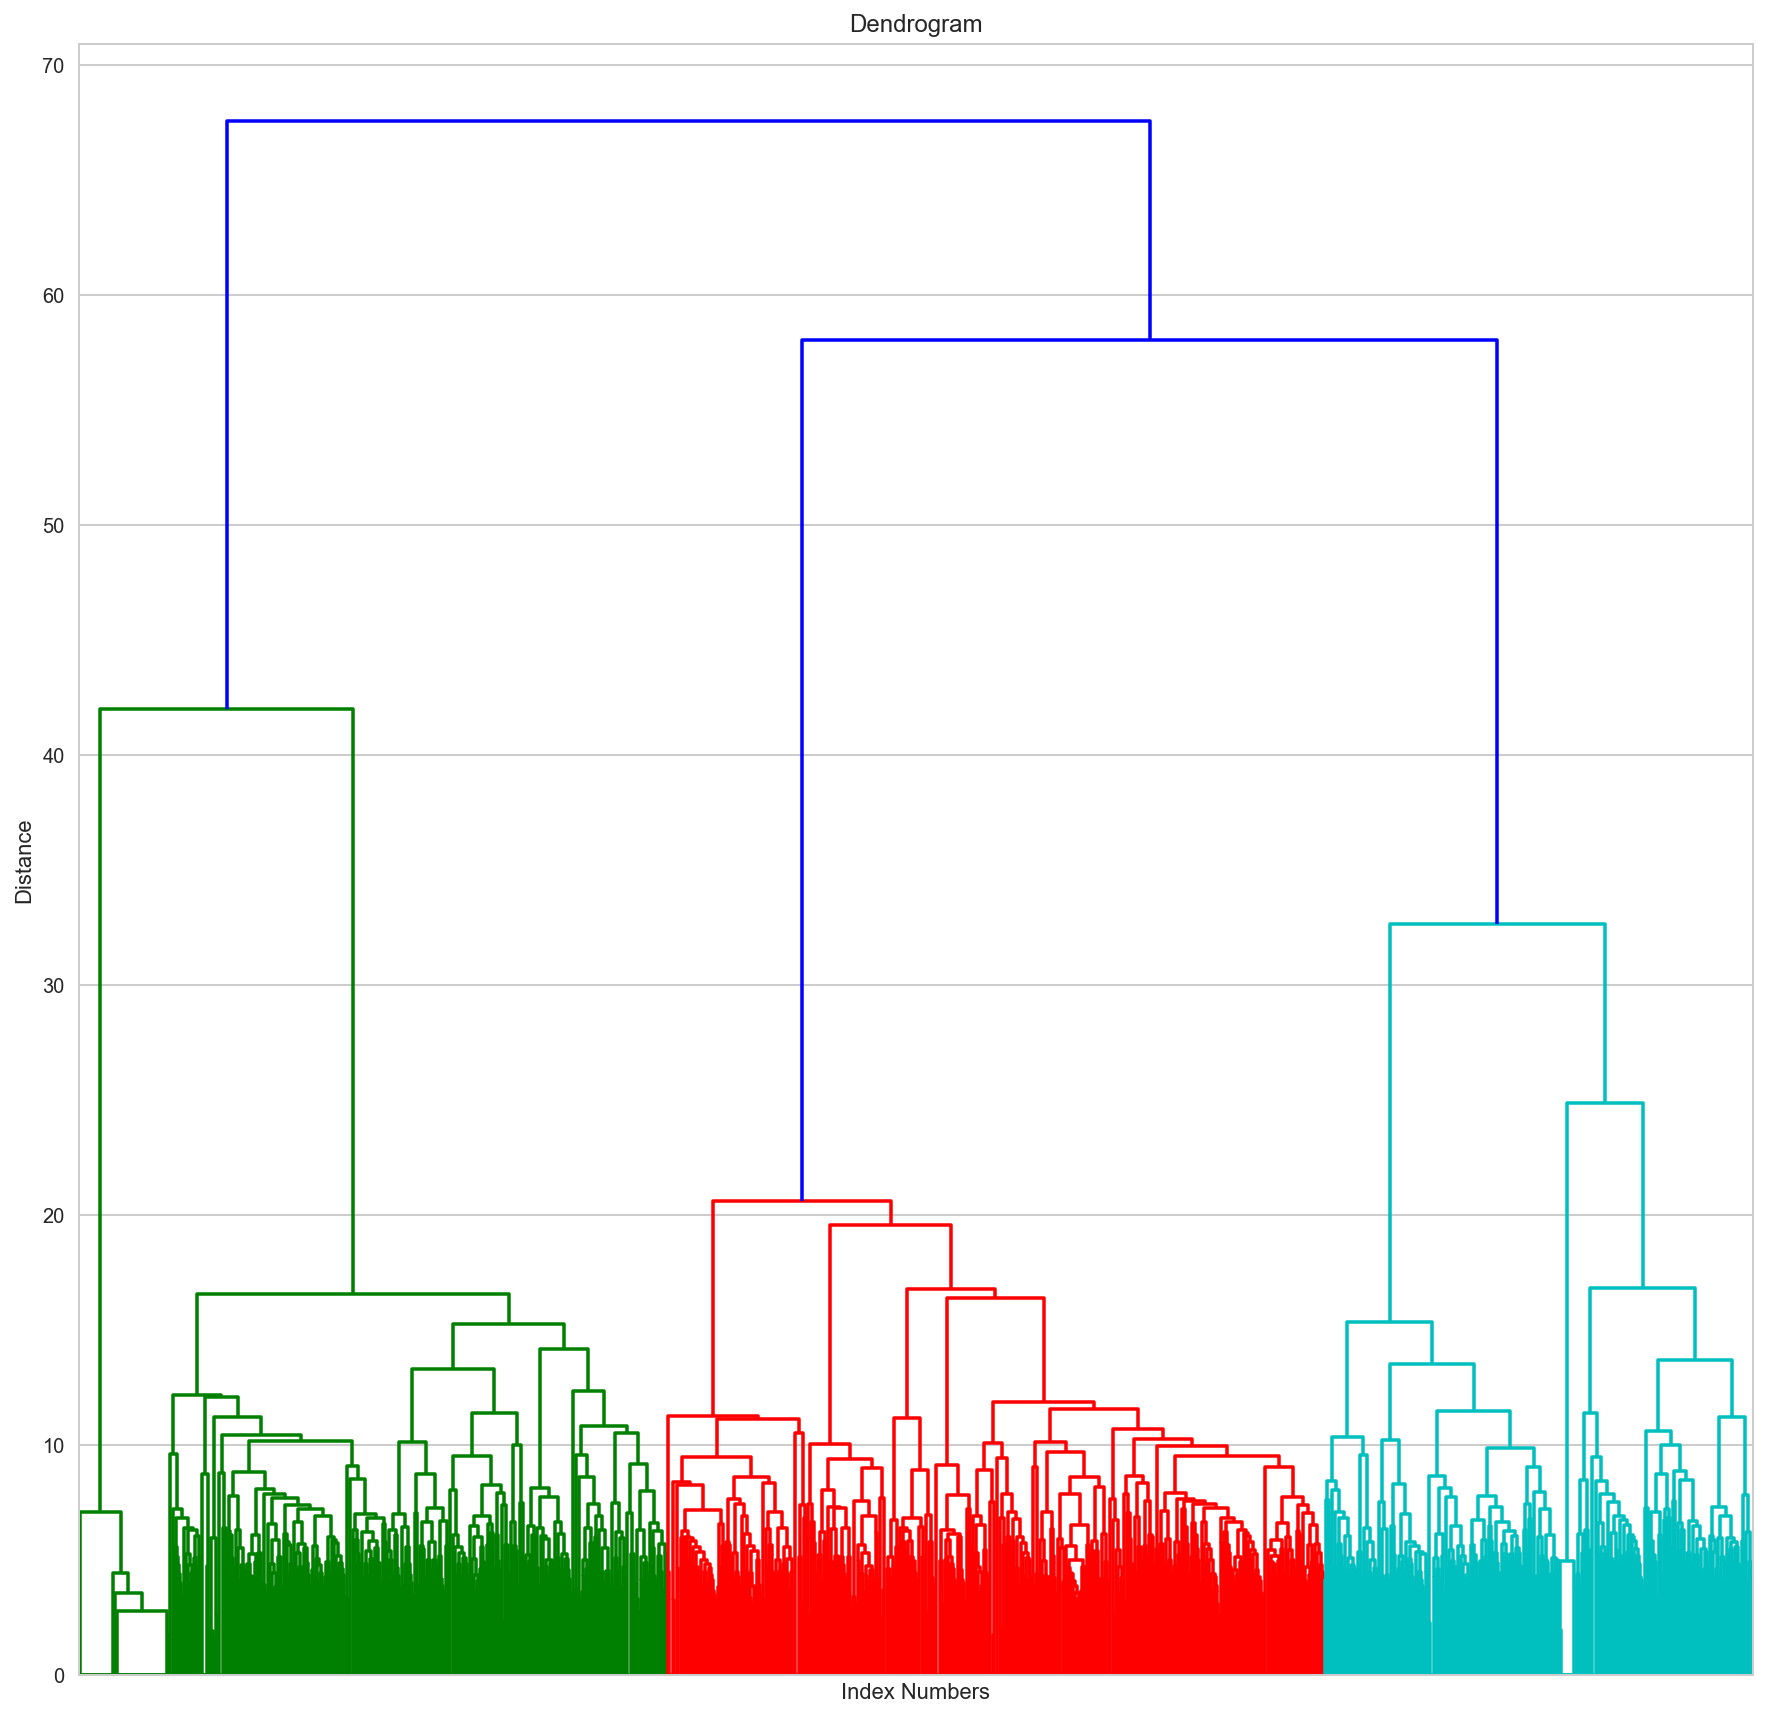

In [56]:
# plotting the dedrogram
plt.figure(figsize=(15,15))
plt.title('Dendrogram')
plt.xlabel('Index Numbers')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90., leaf_font_size=8., no_labels=True)
plt.show()

In [57]:
# The hierarchical clustering shows 3-6 clusters, and the c value indicates that the distances of the
# clusters are fairly well related to the original distances of the data.

In [58]:
max_dist = 200
clusters = fcluster(Z, max_dist, criterion='distance')
clusters

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

### There do seem to be 3-6 clear clusters here, but the hierarchical clustering does not give us much insight into what they are. Topic modeling with LDA might tell us more.

In [76]:
df['snippet_stem_string'][0].split()

[u'we',
 u'are',
 u'look',
 u'for',
 u'an',
 u'experienc',
 u'princip',
 u'level',
 u'data',
 u'scientist',
 u'to',
 u'play',
 u'a',
 u'lead',
 u'role',
 u'on',
 u'our',
 u'data',
 u'scienc',
 u'team',
 u'that',
 u'develop',
 u'and',
 u'maintain',
 u'advanc',
 u'statist']

In [78]:
texts = [text.split() for text in df['snippet_stem_string']]

texts

[[u'we',
  u'are',
  u'look',
  u'for',
  u'an',
  u'experienc',
  u'princip',
  u'level',
  u'data',
  u'scientist',
  u'to',
  u'play',
  u'a',
  u'lead',
  u'role',
  u'on',
  u'our',
  u'data',
  u'scienc',
  u'team',
  u'that',
  u'develop',
  u'and',
  u'maintain',
  u'advanc',
  u'statist'],
 [u'the',
  u'data',
  u'scientist',
  u'analyt',
  u'role',
  u'has',
  u'work',
  u'across',
  u'the',
  u'follow',
  u'four',
  u'area',
  u'build',
  u'key',
  u'data',
  u'set',
  u'to',
  u'empow',
  u'oper',
  u'and',
  u'exploratori',
  u'analysi'],
 [u'amazon',
  u'is',
  u'seek',
  u'a',
  u'data',
  u'scientist',
  u'to',
  u'join',
  u'the',
  u'core',
  u'shop',
  u'team',
  u'previous',
  u'experi',
  u'in',
  u'a',
  u'ml',
  u'or',
  u'data',
  u'scientist',
  u'role',
  u'with',
  u'a',
  u'larg',
  u'technolog',
  u'compani'],
 [u'3',
  u'year',
  u'in',
  u'relev',
  u'experi',
  u'as',
  u'data',
  u'engin',
  u'data',
  u'scientist',
  u'softwar',
  u'engin',
  u'busi',


In [81]:
# getting vector counts on the snippets

cvec_sn = CountVectorizer(stop_words='english', max_features=1000)
cvec_sn.fit(df['snippet_stem_string'])

CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=1000, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [82]:
# Create gensim dictionary object
dictionary = corpora.Dictionary(texts)

# X = vectorizer.fit_transform(df['snippets_stem_string'])

lda3 = models.LdaModel(
    matutils.Sparse2Corpus(cvec_sn.transform(df['snippet_stem_string']), documents_columns=False),
    num_topics  =  3,
    passes      =  20,
    id2word     =  dictionary
)

In [83]:
lda3.print_topics(num_topics=3, num_words=10)

[(0,
  u'0.056*"interest" + 0.050*"scientistus" + 0.048*"exist" + 0.047*"measur" + 0.047*"guidanc" + 0.044*"selfmotiv" + 0.042*"design" + 0.039*"perform" + 0.037*"devic" + 0.037*"scientist"'),
 (1,
  u'0.091*"discov" + 0.088*"through" + 0.041*"worldclass" + 0.024*"success" + 0.013*"scientif" + 0.013*"improv" + 0.013*"solut" + 0.010*"structur" + 0.010*"flow" + 0.009*"deliveri"'),
 (2,
  u'0.080*"worldclass" + 0.077*"design" + 0.043*"selfmotiv" + 0.025*"success" + 0.017*"site" + 0.017*"deliveri" + 0.015*"complex" + 0.013*"seek" + 0.013*"or" + 0.013*"govern"')]

In [84]:
lda3.get_document_topics(dictionary.doc2bow(texts[2]))

[(0, 0.1304333093368662), (1, 0.31882729591712833), (2, 0.55073939474600542)]

In [85]:
topics_labels = {
   0: "Self-motivated Designer",
   1: "Scientist",
   2: "World-class Discoverer"
}

In [86]:
doc_topics3 = [lda3.get_document_topics(dictionary.doc2bow(texts[i])) for i in range(len(texts))]

In [87]:
topic_data = []

for document_id, topics in enumerate(doc_topics3):
    
    document_topics = []
    
    for topic, probability in topics:
       
        topic_data.append({
            'document_id':  document_id,
            'topic_id':     topic,
            'topic':        topics_labels[topic],
            'probability':  probability
        })

topics_df = pd.DataFrame(topic_data)
topics_df.pivot_table(values="probability", index=["document_id", "topic"]).T

document_id  topic                  
0            Scientist                  0.296461
             Self-motivated Designer    0.054437
             World-class Discoverer     0.649101
1            Scientist                  0.480657
             Self-motivated Designer    0.067743
             World-class Discoverer     0.451601
2            Scientist                  0.318816
             Self-motivated Designer    0.130433
             World-class Discoverer     0.550751
3            Scientist                  0.724790
             Self-motivated Designer    0.134166
             World-class Discoverer     0.141044
4            Scientist                  0.735684
             Self-motivated Designer    0.074754
             World-class Discoverer     0.189562
5            Scientist                  0.603451
             Self-motivated Designer    0.155560
             World-class Discoverer     0.240989
6            Scientist                  0.750277
             Self-motivated Desi

In [88]:
lda4 = models.LdaModel(
    matutils.Sparse2Corpus(cvec_sn.transform(df['snippet_stem_string']), documents_columns=False),
    num_topics  =  4,
    passes      =  20,
    id2word     =  dictionary
)

In [89]:
lda4.print_topics(num_topics=4, num_words=10)

[(0,
  u'0.181*"worldclass" + 0.038*"complex" + 0.029*"success" + 0.024*"site" + 0.023*"deliveri" + 0.023*"seek" + 0.022*"metric" + 0.015*"investig" + 0.011*"supportdispel" + 0.011*"or"'),
 (1,
  u'0.104*"design" + 0.059*"selfmotiv" + 0.024*"success" + 0.014*"worldclass" + 0.014*"govern" + 0.013*"or" + 0.013*"scientif" + 0.011*"deliveri" + 0.011*"six" + 0.010*"highdimension"'),
 (2,
  u'0.083*"discov" + 0.079*"through" + 0.025*"worldclass" + 0.022*"interest" + 0.019*"scientistus" + 0.019*"selfmotiv" + 0.018*"exist" + 0.018*"design" + 0.017*"success" + 0.017*"measur"'),
 (3,
  u'0.088*"discov" + 0.085*"through" + 0.020*"govern" + 0.015*"audit" + 0.015*"vapshc" + 0.014*"success" + 0.013*"content" + 0.013*"structur" + 0.012*"marchex" + 0.011*"diseas"')]

In [90]:
lda4.get_document_topics(dictionary.doc2bow(texts[2]))

[(0, 0.39808040665655242),
 (1, 0.21185782106420345),
 (2, 0.23081919486565483),
 (3, 0.15924257741358938)]

In [91]:
topics_labels = {
   0: "Self-motivated Designer Scientist",
   1: "Self-motivated Designer Overseer",
   2: "World-class Designer",
   3: "Discoverer"
}

In [92]:
doc_topics4 = [lda4.get_document_topics(dictionary.doc2bow(texts[i])) for i in range(len(texts))]

In [93]:
topic_data = []

for document_id, topics in enumerate(doc_topics4):
    
    document_topics = []
    
    for topic, probability in topics:
       
        topic_data.append({
            'document_id':  document_id,
            'topic_id':     topic,
            'topic':        topics_labels[topic],
            'probability':  probability
        })

topics_df = pd.DataFrame(topic_data)
topics_df.pivot_table(values="probability", index=["document_id", "topic"]).T

document_id  topic                            
0            Discoverer                           0.138004
             Self-motivated Designer Overseer     0.448524
             Self-motivated Designer Scientist    0.213209
             World-class Designer                 0.200262
1            Discoverer                           0.283197
             Self-motivated Designer Overseer     0.249515
             Self-motivated Designer Scientist    0.172568
             World-class Designer                 0.294720
2            Discoverer                           0.159225
             Self-motivated Designer Overseer     0.211797
             Self-motivated Designer Scientist    0.398102
             World-class Designer                 0.230877
3            Discoverer                           0.015140
             Self-motivated Designer Overseer     0.015392
             Self-motivated Designer Scientist    0.136500
             World-class Designer                 0.832968
4        

In [94]:
lda5 = models.LdaModel(
    matutils.Sparse2Corpus(cvec_sn.transform(df['snippet_stem_string']), documents_columns=False),
    num_topics  =  5,
    passes      =  20,
    id2word     =  dictionary
)

In [95]:
lda5.print_topics(num_topics=5, num_words=10)

[(0,
  u'0.183*"worldclass" + 0.034*"complex" + 0.025*"success" + 0.024*"site" + 0.023*"metric" + 0.021*"seek" + 0.020*"deliveri" + 0.017*"investig" + 0.015*"or" + 0.011*"improv"'),
 (1,
  u'0.105*"discov" + 0.102*"through" + 0.033*"worldclass" + 0.031*"success" + 0.015*"solut" + 0.014*"flow" + 0.012*"govern" + 0.010*"improv" + 0.010*"scientif" + 0.010*"supportdispel"'),
 (2,
  u'0.048*"discov" + 0.046*"through" + 0.024*"scientif" + 0.020*"other" + 0.019*"highdimension" + 0.016*"wa" + 0.016*"aegi" + 0.014*"technic" + 0.011*"help" + 0.010*"compel"'),
 (3,
  u'0.066*"scientistus" + 0.064*"exist" + 0.062*"selfmotiv" + 0.061*"measur" + 0.061*"design" + 0.057*"interest" + 0.052*"guidanc" + 0.052*"perform" + 0.049*"devic" + 0.049*"scientist"'),
 (4,
  u'0.124*"design" + 0.069*"selfmotiv" + 0.022*"success" + 0.015*"worldclass" + 0.014*"deliveri" + 0.014*"govern" + 0.014*"close" + 0.013*"site" + 0.012*"or" + 0.011*"highdimension"')]

In [96]:
lda5.get_document_topics(dictionary.doc2bow(texts[2]))

[(0, 0.23877288184955089),
 (1, 0.20978320728547767),
 (2, 0.14449111016836949),
 (3, 0.083889022400223445),
 (4, 0.3230637782963785)]

In [97]:
topics_labels = {
   0: "Discoverer",
   1: "Scientist",
   2: "Self-motivated Designer",
   3: "World-class Complexity",
   4: "World-class Success Discoverer"
}

In [98]:
doc_topics5 = [lda5.get_document_topics(dictionary.doc2bow(texts[i])) for i in range(len(texts))]

In [99]:
topic_data = []

for document_id, topics in enumerate(doc_topics5):
    
    document_topics = []
    
    for topic, probability in topics:
       
        topic_data.append({
            'document_id':  document_id,
            'topic_id':     topic,
            'topic':        topics_labels[topic],
            'probability':  probability
        })

topics_df = pd.DataFrame(topic_data)
topics_df.pivot_table(values="probability", index=["document_id", "topic"]).T

document_id  topic                         
0            Discoverer                        0.269701
             Scientist                         0.236878
             Self-motivated Designer           0.082634
             World-class Complexity            0.102550
             World-class Success Discoverer    0.308236
1            Discoverer                        0.156429
             Scientist                         0.108089
             Self-motivated Designer           0.188464
             World-class Complexity            0.055443
             World-class Success Discoverer    0.491574
2            Discoverer                        0.238743
             Scientist                         0.209780
             Self-motivated Designer           0.144511
             World-class Complexity            0.083889
             World-class Success Discoverer    0.323076
3            Discoverer                        0.075627
             Scientist                         0.561154
    

In [100]:
lda6 = models.LdaModel(
    matutils.Sparse2Corpus(cvec_sn.transform(df['snippet_stem_string']), documents_columns=False),
    num_topics  =  6,
    passes      =  20,
    id2word     =  dictionary
)

In [101]:
lda6.print_topics(num_topics=6, num_words=10)

[(0,
  u'0.056*"through" + 0.056*"discov" + 0.041*"worldclass" + 0.036*"solut" + 0.017*"engineerdevelop" + 0.015*"roadmap" + 0.013*"highdimension" + 0.013*"time" + 0.012*"improv" + 0.010*"verifi"'),
 (1,
  u'0.059*"design" + 0.056*"scientistus" + 0.055*"selfmotiv" + 0.055*"exist" + 0.054*"measur" + 0.048*"interest" + 0.045*"perform" + 0.044*"guidanc" + 0.042*"scientist" + 0.042*"devic"'),
 (2,
  u'0.090*"design" + 0.046*"selfmotiv" + 0.032*"site" + 0.020*"close" + 0.017*"scientif" + 0.016*"deliveri" + 0.014*"vapshc" + 0.014*"imag" + 0.012*"or" + 0.012*"trend"'),
 (3,
  u'0.190*"worldclass" + 0.031*"success" + 0.026*"complex" + 0.024*"metric" + 0.023*"deliveri" + 0.018*"supportdispel" + 0.015*"improv" + 0.015*"or" + 0.014*"site" + 0.013*"structur"'),
 (4,
  u'0.119*"design" + 0.066*"selfmotiv" + 0.038*"success" + 0.026*"worldclass" + 0.020*"govern" + 0.018*"space" + 0.016*"web" + 0.016*"seek" + 0.014*"six" + 0.011*"experi"'),
 (5,
  u'0.122*"discov" + 0.118*"through" + 0.028*"success" +

In [102]:
lda6.get_document_topics(dictionary.doc2bow(texts[2]))

[(1, 0.14351817777197978),
 (2, 0.1912076121131607),
 (3, 0.31194202628821538),
 (4, 0.18618310313625586),
 (5, 0.16093447059491275)]

In [103]:
topics_labels = {
   0: "Self-motivated Designer",
   1: "Disease Discoverer",
   2: "High-dimension Flow Discoverer",
   3: "Self-motivated Designer-Scientist",
   4: "World-class Designer",
   5: "Self-motivated Designer"
}

In [104]:
doc_topics6 = [lda6.get_document_topics(dictionary.doc2bow(texts[i])) for i in range(len(texts))]

In [105]:
topic_data = []

for document_id, topics in enumerate(doc_topics6):
    
    document_topics = []
    
    for topic, probability in topics:
       
        topic_data.append({
            'document_id':  document_id,
            'topic_id':     topic,
            'topic':        topics_labels[topic],
            'probability':  probability
        })

topics_df = pd.DataFrame(topic_data)
topics_df.pivot_table(values="probability", index=["document_id", "topic"]).T

document_id  topic                            
0            Disease Discoverer                   0.087417
             High-dimension Flow Discoverer       0.139195
             Self-motivated Designer              0.160106
             Self-motivated Designer-Scientist    0.290367
             World-class Designer                 0.316634
1            Disease Discoverer                   0.073066
             High-dimension Flow Discoverer       0.208800
             Self-motivated Designer              0.276409
             Self-motivated Designer-Scientist    0.335584
             World-class Designer                 0.098847
2            Disease Discoverer                   0.143520
             High-dimension Flow Discoverer       0.191217
             Self-motivated Designer              0.160905
             Self-motivated Designer-Scientist    0.311988
             World-class Designer                 0.186155
3            Disease Discoverer                   0.065645
         

In [106]:
# The more clusters I considered, the harder it got to differentiate the topics generated by the model, which
# suggests that there are only about three meaningful clusters here: Self-motivated Designer, Scientist, and
# World-class Discoverer.